# Capstone Project:  Face Shape Classification - Part 2

This notebook further Explore Data and Image Preprocessing prior to modelling.  This includes the following:

1. Image cropping & resizing by maintaining aspect ratio.
2. Face Detection with Bounding Box
3. Explore different image colors & filters
4. Prepare data and export files for modelling



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libaries & Define initial functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
from scipy import ndimage
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import pickle
from torch.nn.functional import one_hot


%matplotlib inline


In [3]:
def create_data_files(directory, array, type=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)

        if type == 'aspect':
            try:
                for img in img_list:
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # read in default color Grayscale
                    img_array = crop_and_resize(img_array) # call a function to crop & resize maintain aspect ratio
                    array.append([img_array, class_num])
                    i += 1
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        elif type == 'gray':
            try:
                for img in img_list:
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    gray_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2GRAY) # convert to Gray
                    array.append([gray_array, class_num])   # 0=image, 1=class
                    i += 1
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        elif type == 'rgb':
            try:
                for img in img_list:
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    rgb_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2RGB) # convert to RGB
                    array.append([rgb_array, class_num])   # 0=image, 1=class
                    i += 1
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        else:
            print("Please specify image type ['aspect', 'gray', 'rgb']")
            break

        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")


In [4]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [5]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

In [6]:
def train_test_prep(training_data_array, testing_data_array):

    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

def train_test_prep(training_data_array, testing_data_array):
    # shuffle the images to mix all the classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into arrays
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # Convert to numpy arrays and normalize
    X_train = np.array(X_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)

    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Convert labels to one-hot encoded tensors
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_train = one_hot(y_train, num_classes=5).float()

    y_test = torch.tensor(y_test, dtype=torch.long)
    y_test = one_hot(y_test, num_classes=5).float()

    # Convert features to tensors and add channel dimension
    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)

    # Add channel dimension if images are grayscale (1 channel)
    if X_train.ndim == 3:
        X_train = X_train.unsqueeze(1)  # Shape becomes [N, 1, H, W]
        X_test = X_test.unsqueeze(1)

    return X_train, X_test, y_train, y_test

In [7]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = '/content/drive/MyDrive/CV Project/Pickle Files'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [8]:
# Assign the drives for image data, and specify the classes / labels
train_dir = '/content/drive/MyDrive/CV Project/FaceShape Dataset/training_set'
test_dir = '/content/drive/MyDrive/CV Project/FaceShape Dataset/testing_set'
categories = ['Heart','Oblong','Oval','Round','Square']
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

In [9]:
# create path to images in examples

ex_path = '/content/drive/MyDrive/CV Project/examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)

examples = sorted(examples)
examples

['/content/drive/MyDrive/CV Project/examples/heart (13).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (3).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (37).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (5).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (7).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (11).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (13).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (14).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (15).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (21).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (16).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (2).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (25).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (32).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (8).jpg',
 '/content/drive/MyDrive/CV Project/examples/round (1).jpg',
 '/content/dri

## 1. Image cropping & resizing by maintaining aspect ratio.

From previous EDA in Part 1, when we resized all images by 224x224, the images that were not originally a square image will look distorted.

In [10]:
# Let's define a function to resize image by maintaing aspect ratio, but some parts of image will need to be cropped out

def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [11]:
portrait = cv2.imread(
    '/content/drive/MyDrive/CV Project/FaceShape Dataset/testing_set/Heart/heart (102).jpg',
    cv2.IMREAD_GRAYSCALE)
landscape = cv2.imread(
    '/content/drive/MyDrive/CV Project/FaceShape Dataset/testing_set/Heart/heart (13).jpg',
    cv2.IMREAD_GRAYSCALE)


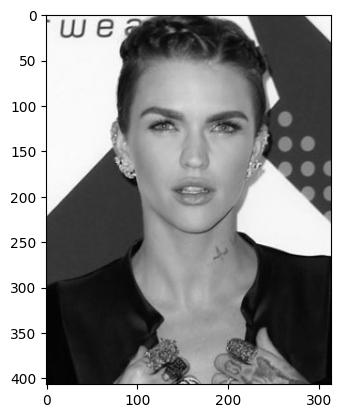

In [12]:
# original image
plt.imshow(portrait,cmap='gray');

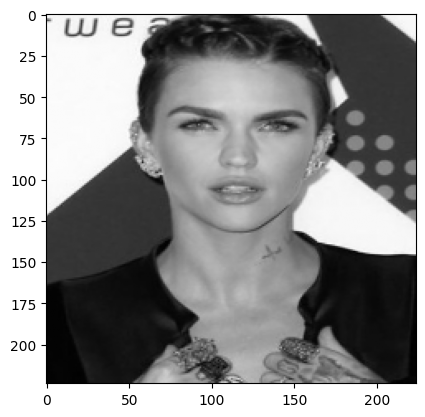

In [13]:
# auto resize by 224 - will be distorted
resized_ptrt = cv2.resize(portrait,(224,224))
plt.imshow(resized_ptrt, cmap='gray')

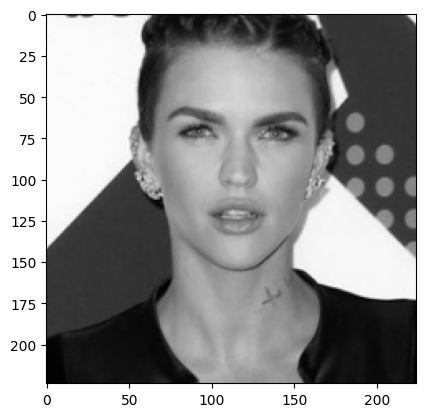

In [14]:
# test if the function works on portrait photos
new_ptrt = crop_and_resize(portrait)
plt.imshow(new_ptrt,cmap='gray');

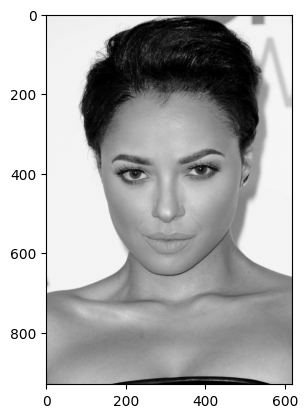

In [15]:
# original image
plt.imshow(landscape,cmap='gray');

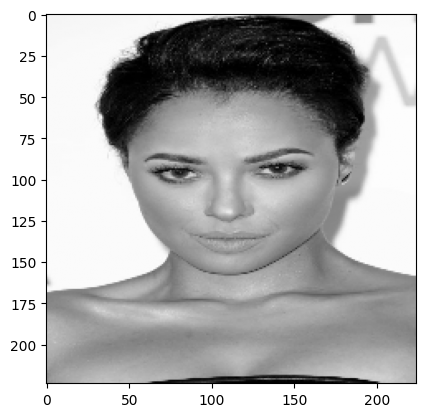

In [16]:
# auto resize by 224 - will be distorted
resized_lscp = cv2.resize(landscape,(224,224))
plt.imshow(resized_lscp, cmap='gray')

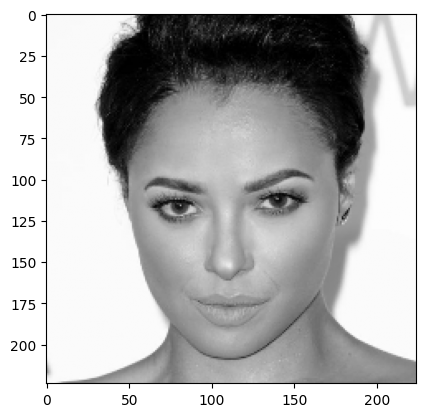

In [17]:
# test if the function works on landscape photos
new_lscp = crop_and_resize(landscape)
plt.imshow(new_lscp,cmap='gray');

## 2. Face Detection with Bounding Box

Although the images in the previous approach kept aspect ratio, but some of the images are more face-focused, while others are zoomed out beyond the face (i.e. shoulder & outfit).  In the next iteration, let's try to detect the face in an image with a bounding box.

In [18]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.5 MB/s eta 0:00:00


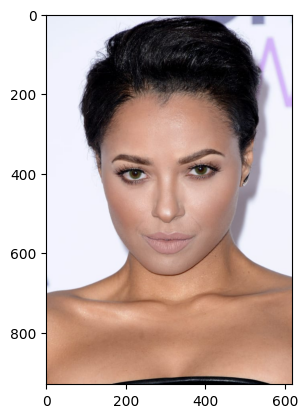

In [19]:
img = cv2.imread('/content/drive/MyDrive/CV Project/FaceShape Dataset/testing_set/Heart/heart (13).jpg')
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img2);


In [20]:
# creates detector
detector = MTCNN()
# detect faces in an image
results = detector.detect_faces(img2)
results

[{'box': [153, 210, 331, 450],
  'confidence': np.float64(0.9891793727874756),
  'keypoints': {'nose': [np.int64(302), np.int64(507)],
   'mouth_right': [np.int64(379), np.int64(558)],
   'right_eye': [np.int64(389), np.int64(393)],
   'left_eye': [np.int64(226), np.int64(401)],
   'mouth_left': [np.int64(248), np.int64(572)]}}]

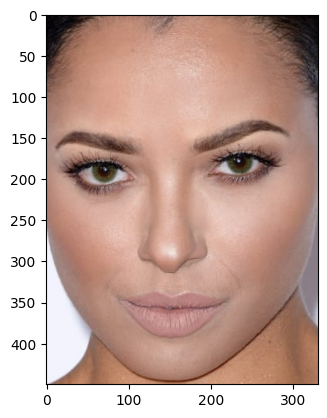

In [21]:
# extract the bounding box from the face

x1, y1, width, height = results[0]['box']
x2, y2 = x1+width, y1+height

face = img2[y1:y2, x1:x2]
plt.imshow(face);

We've detected the face, but the cropping was too tight and we're not seeing full face (i.e. chin & forehead).  Let's extend a few pixels on the top & bottom

x1 = 153
x2 = 484
y1 = 210
y2 = 660


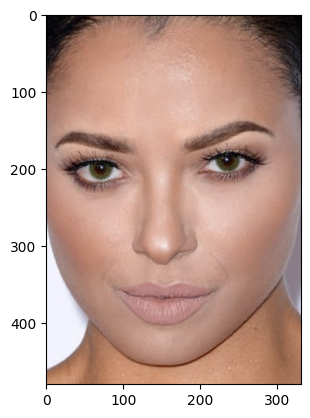

In [22]:
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

# first fix the heights by adding 10 pix each side
face_2 = img2[y1-10:y2+20, x1:x2];
plt.imshow(face_2);

Now let's expand the width on both sides to be a square

h=480
w=331


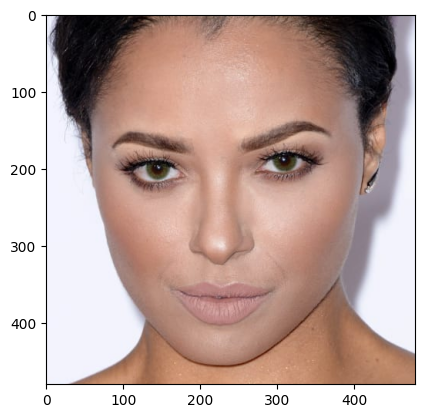

In [23]:
# then add the width to be square
h = (y2+20) - (y1-10)
w = x2-x1
print(f'h={h}')
print(f'w={w}')

adj_h = 10
adj_w = int((h-w)/2)

new_y1 = y1-adj_h
new_y2 = y2+(adj_h*2)

new_x1 = x1-adj_w
new_x2 = x2+adj_w

new_face = img2[new_y1:new_y2, new_x1:new_x2]
plt.imshow(new_face);


## 3. Explore different image colors & filters

#### Explore different color channels

This project will focus on exploring GRAYSCALE and RGB colors.
- The BGR is default OpenCV color channel, however it is just rearranging of the dimensions of the 3D array.  Hence the focus will be only on RGB.
- HSV option seems to detect the edges well (with green hightlight), however when experimenting in the CNN modelling it performed well only on some labels (Oblong-86%), while not so well at predicting other shapes (Heart-43%, Oval-50%), hence we will exclude it from the project as it requires increased in storage size and computing power.

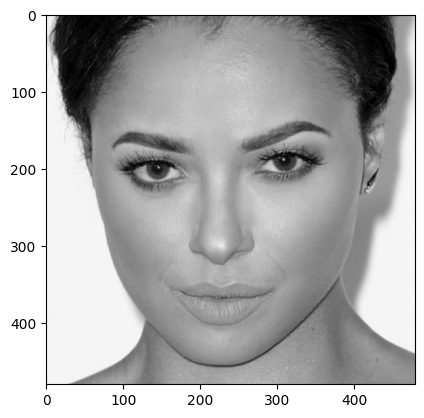

In [24]:
gray = cv2.cvtColor(new_face,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray');

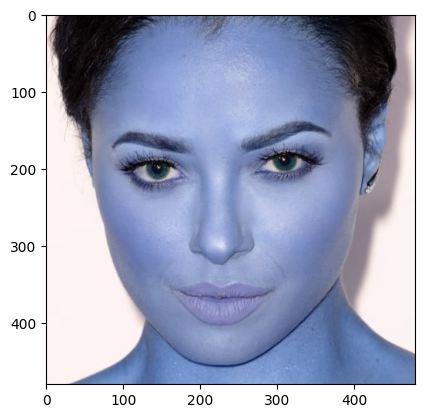

In [25]:
bgr = cv2.cvtColor(new_face,cv2.COLOR_RGB2BGR)
plt.imshow(bgr);

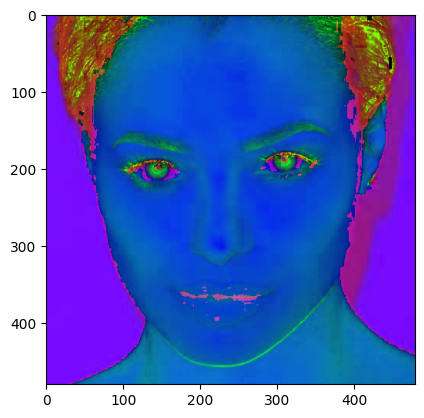

In [26]:
hsv = cv2.cvtColor(new_face,cv2.COLOR_RGB2HSV)
plt.imshow(hsv,cmap='gray');

#### Explore different filters

Note:  The exploration of filters may not be used in CNN, but may be more useful for Machine Learning feature extraction.

The entropy and blur images did not show the face shape well, hence will not be used.

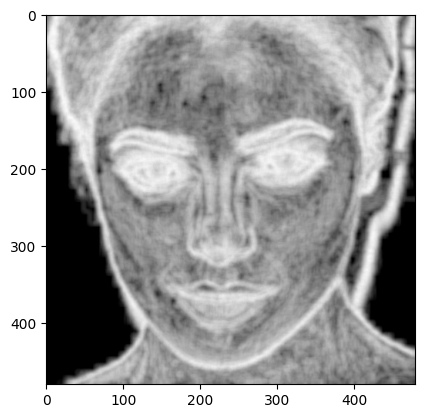

In [27]:
entropy = entropy(gray,disk(5))
plt.imshow(entropy,cmap='gray');


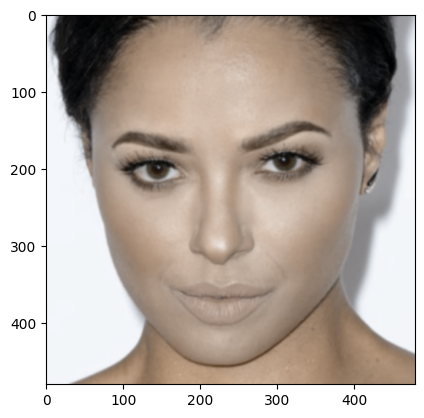

In [28]:
blur = gaussian(new_face)
plt.imshow(blur);

Scharr and Sobel are similar.

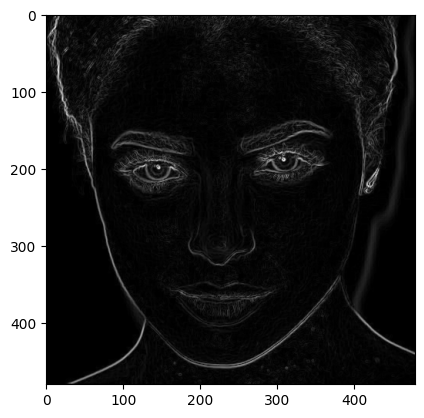

In [29]:
scharr_img = scharr(gray)

plt.imshow(scharr_img, cmap='gray');

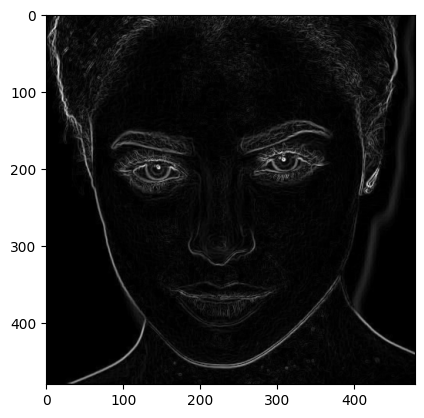

In [30]:
sobel_img = sobel(gray)
plt.imshow(sobel_img, cmap='gray');


Canny Edge with sigma of 1.5 to 2 seems to detect the edges well.

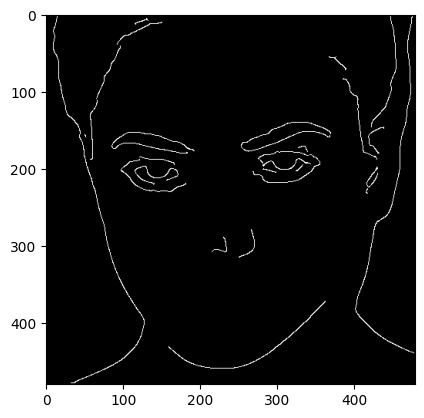

In [31]:
canny_img = canny(gray, sigma = 3)
plt.imshow(canny_img, cmap='gray');

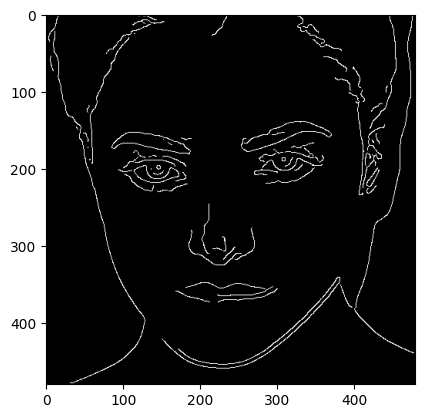

In [32]:
canny_img = canny(gray, sigma = 2)
plt.imshow(canny_img, cmap='gray');

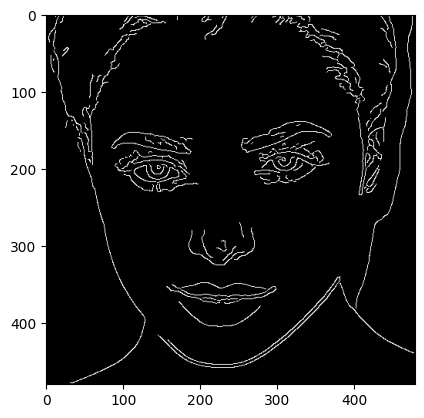

In [33]:
canny_img = canny(gray, sigma = 1.5)
plt.imshow(canny_img, cmap='gray');

Gabor filter with high contrast seems to detect the edges also.

In [34]:
def cvt_gabor(gray_img):
    ksize = 3
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0

    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gb_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)

    return(gb_img)


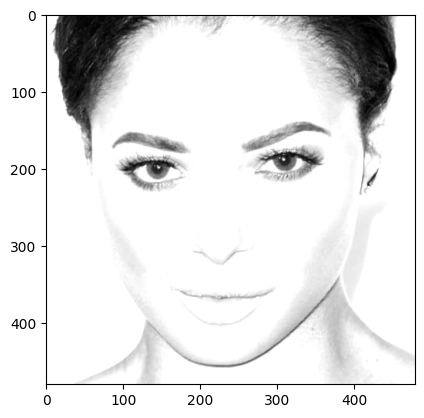

In [35]:
gabor_test = cvt_gabor(gray)
plt.imshow(gabor_test,cmap='gray');

## Let' put it all together...

In [36]:
# detector = MTCNN()  # creates detector

def extract_face(img, target_size=(224,224)):
    '''this functions extract face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling'''

    # 1. detect faces in an image

    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img




In [37]:
# test the function on the examples

n_images = len(examples)

fig, ax = plt.subplots(nrows=7, ncols=n_images, figsize=(n_images*2.5, (7*2.5)))
plt.gray()

ax= ax.ravel()

for i, file in enumerate(examples):

    img = cv2.imread(file)
    new_img = extract_face(img) # call function to extract face

    rsz_img = cv2.resize(img,(224,224))
    rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
    ax[i].imshow(rsz_img)
    ax[i].axis('off')

    aspct_img = crop_and_resize(img, target_w=224, target_h=224)
    aspct_img = cv2.cvtColor(aspct_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*1)].imshow(aspct_img)
    ax[i+(n_images*1)].axis('off')

    rgb_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
    ax[i+(n_images*3)].imshow(rgb_img)
    ax[i+(n_images*3)].axis('off')

    gray_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*2)].imshow(gray_img)
    ax[i+(n_images*2)].axis('off')

    gabor_img = cvt_gabor(gray_img)
    ax[i+(n_images*4)].imshow(gabor_img)
    ax[i+(n_images*4)].axis('off')

    sobel_img = sobel(gray_img)
    ax[i+(n_images*5)].imshow(sobel_img)
    ax[i+(n_images*5)].axis('off')

    canny_img = canny(gray_img, sigma=1.5)
    ax[i+(n_images*6)].imshow(canny_img)
    ax[i+(n_images*6)].axis('off')

plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.figtext(x=0.105, y=0.8, s="Auto Resize", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.68, s="w/Aspect Ratio", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.6, s="BBox", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.48, s="BBox-RGB", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.37, s="BBox-Gabor", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.26, s="BBox-Sobel", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.13, s="BBox-Canny Edges", fontsize=15, rotation=90)
plt.figtext(x=0.16, y=0.89, s="Heart", fontsize=15)
plt.figtext(x=0.26, y=0.89, s="Oblong", fontsize=15)
plt.figtext(x=0.38, y=0.89, s="Oval", fontsize=15)
plt.figtext(x=0.49, y=0.89, s="Round", fontsize=15)
plt.figtext(x=0.6, y=0.89, s="Square", fontsize=15)
plt.figtext(x=0.68, y=0.89, s="|", fontsize=15)
plt.figtext(x=0.7, y=0.89, s="Long Portrait", fontsize=15)
plt.figtext(x=0.8, y=0.89, s="Wide Landscape", fontsize=15);


Output hidden; open in https://colab.research.google.com to view.

## Prepare `train_test` data and export for modelling

**Version APR:** Crop & Resize - maintaining aspect ratio (This will be in Model 2)

Note: Model 1 is auto resize to 224x224 (Part 1 of the project notebook)

In [38]:
# create new training & testing data with resizing

training_data_apr = []
testing_data_apr = []

create_data_files(train_dir, training_data_apr, 'aspect')
create_data_files(test_dir, testing_data_apr, 'aspect')


In [39]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_apr, testing_data_apr)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape torch.Size([510, 1, 224, 224])
X_test.shape torch.Size([125, 1, 224, 224])
y_train.shape torch.Size([510, 5])
y_test.shape torch.Size([125, 5])


In [40]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (510, 224, 224, 1)
X_test.shape (125, 224, 224, 1)
y_train.shape torch.Size([510, 5])
y_test.shape torch.Size([125, 5])


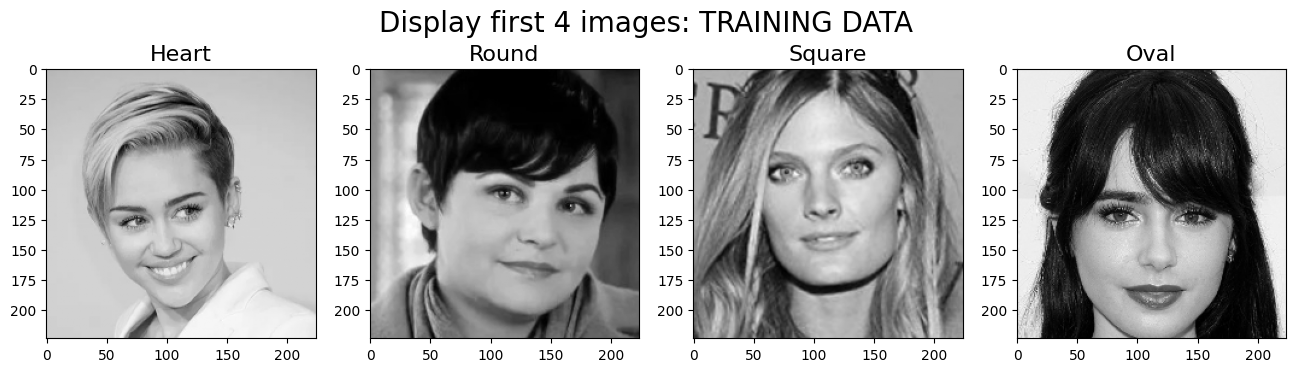

In [41]:
show_img(4, training_data_apr[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

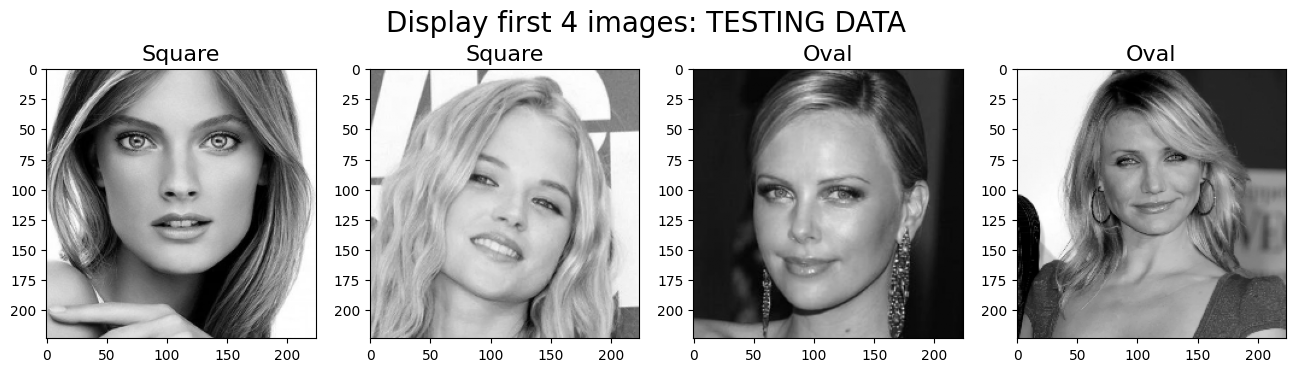

In [42]:
show_img(4, testing_data_apr[:4], 'Display first 4 images: TESTING DATA', ncols=4)

In [43]:
# need to comment out this part after running this code & generating pickle files
# otherwise it will append to existing file everytime we run it

pickle_out(X_train, X_test, y_train, y_test, 'apr')